In [1]:
!python --version

Python 3.6.3 :: Anaconda, Inc.


In [2]:
import os
import io
import sys
import datetime
import requests
import urllib.request
import json
import zipfile
import numpy as np
import pandas as pd
import tweepy
import psycopg2
from sqlalchemy import create_engine
from datetime import date, timedelta
import geopandas as gpd
import shapely
import seaborn as sns
import pylab as pl
from libpysal.weights.contiguity import Queen
from esda.moran import Moran
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from esda.moran import Moran_Local

%pylab inline

sys.path.append('../')
from envir import config

Populating the interactive namespace from numpy and matplotlib


### Obtain NYC ZipCodes & NYC PUMAS Shapefile

In [3]:
# nyc zip codes
zip_url = 'https://data.ny.gov/api/views/juva-r6g2/rows.csv?accessType=DOWNLOAD'
urllib.request.urlretrieve(zip_url, config.shared+'ny_zip_demographics.csv')

# us zips with lat long
zip_url = 'https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2019_Gazetteer/2019_Gaz_zcta_national.zip'
urllib.request.urlretrieve(zip_url, config.shared+'2019_Gaz_zcta_national.zip')
    
with zipfile.ZipFile(config.shared+'Gaz_zcta_national_2019.zip', 'r') as zip_ref:
    zip_ref.extractall(config.shared)

In [4]:
# NYC PUMAS shapefile
zip_url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
urllib.request.urlretrieve(zip_url, config.shared+'NYC_PUMAS.zip')

with zipfile.ZipFile(config.shared+'NYC_PUMAS.zip', 'r') as zip_ref:
    zip_ref.extractall(config.shared+'/NYC_PUMAS')
    
# rename the files in the unzipped folder
for file in os.listdir(config.shared+'/NYC_PUMAS/'):
    path = (config.shared+'/NYC_PUMAS'+'/')
    if file.endswith(".dbf"):
        os.rename(path + file, path + 'NYC_PUMAS' + '.dbf')
    if file.endswith(".prj"):
        os.rename(path + file, path + 'NYC_PUMAS' + '.prj')
    if file.endswith(".shp"):
        os.rename(path + file, path + 'NYC_PUMAS' + '.shp')
    if file.endswith(".shx"):
        os.rename(path + file, path + 'NYC_PUMAS' + '.shx')

In [5]:
# NYC Census Tracts    
zip_url = 'https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=Shapefile'
urllib.request.urlretrieve(zip_url, config.shared+'NYC_CENSUS.zip')

with zipfile.ZipFile(config.shared+'NYC_CENSUS.zip', 'r') as zip_ref:
    zip_ref.extractall(config.shared+'/NYC_CENSUS')
    
# rename the files in the unzipped folder
for file in os.listdir(config.shared+'/NYC_CENSUS/'):
    path = (config.shared+'/NYC_CENSUS'+'/')
    if file.endswith(".dbf"):
        os.rename(path + file, path + 'NYC_CENSUS' + '.dbf')
    if file.endswith(".prj"):
        os.rename(path + file, path + 'NYC_CENSUS' + '.prj')
    if file.endswith(".shp"):
        os.rename(path + file, path + 'NYC_CENSUS' + '.shp')
    if file.endswith(".shx"):
        os.rename(path + file, path + 'NYC_CENSUS' + '.shx')

### Read in the Downloaded Files

In [6]:
us_zips = pd.read_csv(config.shared+'2019_Gaz_zcta_national.txt', sep="\t")
us_zips.head()

,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,601,166659747,799292,64.348,0.309,18.180555,-66.749961
1,602,79307534,4428428,30.621,1.710,18.361945,-67.175597
2,603,81887188,181412,31.617,0.070,18.455183,-67.119887
3,606,109579993,12487,42.309,0.005,18.158327,-66.932928
4,610,93013428,4172059,35.913,1.611,18.294032,-67.127156


In [7]:
ny_zips = pd.read_csv(config.shared+'ny_zip_demographics.csv', sep=',')
nyc_zips = ny_zips[ny_zips['County Name'].isin(['New York', 'Kings', 'Queens','Richmond','Bronx'])]
nyc_zips = pd.merge(nyc_zips, us_zips, how='inner', left_on='ZIP Code', right_on = 'GEOID')
nyc_zips.rename(str.strip, axis='columns', inplace=True)
nyc_zips.head()

,County Name,State FIPS,County Code,County FIPS,ZIP Code,File Date,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,Bronx,36,5,36005,10472,07/25/2007,10472,2729341,0,1.054,0.000,40.829556,-73.869310
1,Bronx,36,5,36005,10463,07/25/2007,10463,3755855,345779,1.450,0.134,40.880678,-73.906540
2,New York,36,61,36061,10463,07/25/2007,10463,3755855,345779,1.450,0.134,40.880678,-73.906540
3,Bronx,36,5,36005,10468,07/25/2007,10468,2773214,45100,1.071,0.017,40.868940,-73.899995
4,Bronx,36,5,36005,10457,07/25/2007,10457,2743123,0,1.059,0.000,40.847162,-73.898663


In [8]:
nyc_zips.shape

(224, 13)

In [9]:
nyc_zips[nyc_zips.ALAND_SQMI==max(nyc_zips.ALAND_SQMI)]

,County Name,State FIPS,County Code,County FIPS,ZIP Code,File Date,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
113,Richmond,36,85,36085,10314,07/25/2007,10314,35432499,1687746,13.681,0.652,40.599263,-74.165748


In [10]:
nyc_zips[nyc_zips.ALAND_SQMI==min(nyc_zips.ALAND_SQMI)]

,County Name,State FIPS,County Code,County FIPS,ZIP Code,File Date,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
71,New York,36,61,36061,10177,07/25/2007,10177,5421,0,0.002,0.0,40.755139,-73.975934


In [11]:
# then read it in with geopandas, reading in the shape file with the function 
pumas = gpd.GeoDataFrame.from_file(config.shared+'/NYC_PUMAS' +'/'+ 'NYC_PUMAS.shp')
pumas.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792841e+07,53226.681270,"POLYGON ((-73.89641 40.90450, -73.89636 40.903..."
1,3702,1.889860e+08,106049.945667,"POLYGON ((-73.86477 40.90201, -73.86305 40.901..."
2,3703,2.676444e+08,305248.062003,"MULTIPOLYGON (((-73.78833 40.83467, -73.78931 ..."
3,3704,1.062136e+08,47970.789058,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
4,4006,6.184990e+07,42555.863159,"POLYGON ((-73.92916 40.68344, -73.92901 40.682..."


In [12]:
pumas.crs
pumas['centroid'] = pumas['geometry'].centroid
pumas['lon'] = pumas['centroid'].apply(lambda p: p.x)
pumas['lat'] = pumas['centroid'].apply(lambda p: p.y)

In [13]:
pumas.head()

,puma,shape_area,shape_leng,geometry,centroid,lon,lat
0,3701,9.792841e+07,53226.681270,"POLYGON ((-73.89641 40.90450, -73.89636 40.903...",POINT (-73.90488 40.88944),-73.904880,40.889442
1,3702,1.889860e+08,106049.945667,"POLYGON ((-73.86477 40.90201, -73.86305 40.901...",POINT (-73.86164 40.89000),-73.861644,40.890003
2,3703,2.676444e+08,305248.062003,"MULTIPOLYGON (((-73.78833 40.83467, -73.78931 ...",POINT (-73.81588 40.85103),-73.815880,40.851031
3,3704,1.062136e+08,47970.789058,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",POINT (-73.85254 40.85618),-73.852544,40.856177
4,4006,6.184990e+07,42555.863159,"POLYGON ((-73.92916 40.68344, -73.92901 40.682...",POINT (-73.94397 40.67499),-73.943969,40.674995


In [14]:
# then read it in with geopandas, reading in the shape file with the function 
census = gpd.GeoDataFrame.from_file(config.shared+'/NYC_CENSUS' +'/'+ 'NYC_CENSUS.shp')
census['centroid'] = census['geometry'].centroid
census['lon'] = census['centroid'].apply(lambda p: p.x)
census['lat'] = census['centroid'].apply(lambda p: p.y)
census.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,centroid,lon,lat
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((-74.07921 40.64343, -74.07914 40.643...",POINT (-74.08286 40.64220),-74.082856,40.642204
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((-73.96433 40.75638, -73.96479 40.755...",POINT (-73.96777 40.75579),-73.967775,40.755788
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((-73.96802 40.75958, -73.96848 40.758...",POINT (-73.97123 40.75807),-73.971232,40.758066
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((-73.97124 40.76094, -73.97170 40.760...",POINT (-73.97445 40.75942),-73.974449,40.759424
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((-73.97446 40.76229, -73.97491 40.761...",POINT (-73.97767 40.76078),-73.977673,40.760779


### Set Connection to DB

In [15]:
engine = create_engine('postgresql+psycopg2:///yelp_abcs')
conn = engine.connect()

In [16]:
conn

### Search for Tweets By PUMAS and Search Terms

In [17]:
tweets = pd.read_sql('''SELECT * FROM stag.twitter_results''', conn, parse_dates=True)

In [40]:
tweets.head(50)[['user_name', 'id', 'text']]

,user_name,id,text
0,Kathryn Markel Fine Arts,1333108850896089091,It’s that time of year again! As you shop for ...
1,.,1333659726094225411,Ladies remember!! You can have your bf bring y...
2,🇹🇹,1333262426427568128,Damn this UberEats nigga was dead ass on a ped...
3,M.A Salamanca,1333229474540818432,I've deleted and uninstalled Ubereats. Too man...
4,J-HOT (Don Sazón),1332898875464577024,Nahhhh 🤦🏽‍♂️ fuckin UberEats delivery ppl be t...
5,hutch,1334582598941757440,@ShaiMW what i started doing was telling my qa...
6,hutch,1334582598941757440,@ShaiMW what i started doing was telling my qa...
7,Daniel,1334266030563209218,DoorDash and I have the same plans for the win...
8,Dave Snyder,1333775771626835973,@ohwhen @DoorDash Nice Owen! Congrats.
9,The Infamous Rogue Agent Stringer Bell,1333633496183676928,Shout out to @DoorDash for that quick late del...


In [19]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
tweets['created_at_hour'] = tweets['created_at'].dt.hour
tweets['count'] = tweets['created_at_hour'].map( lambda x: 1 if x >=18 or x <= 6 else 0) # filter for evening and night hours

In [20]:
sum(tweets['count'])

486

In [21]:
tweets.shape

(684, 11)

In [22]:
len(tweets.id.unique())

110

### Access the Census API - American Community Survey (ACS) 5 Year

In [23]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs5/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)
affkeys = np.array(list(aff1y['variables'].keys()))

In [24]:
#extracting variables of B00001 that contain "population"
popKey = [(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B00001") and 
          'POPULATION' in aff1y['variables'][k]['concept']]

In [25]:
# getting the population estimates per puma
url = "https://api.census.gov/data/2016/acs/acs5?get=" + popKey[0][0] +\
    ",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + config.census
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,15593,"St. Lawrence County PUMA, New York",36,100,NaN
1,22735,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,14338,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,14617,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,14963,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [26]:
pumaPop['puma'] = pumaPop['public use microdata area'].map(str)
pumas = pd.merge(pumas, pumaPop, how='inner', on='puma')

### Merge PUMAS with Twitter Results Count

In [27]:
nightTweetsSumPuma = tweets[tweets['count']==1].groupby(['puma']).count().reset_index()
nightTweetsSumPuma.head()

,puma,created_at,user_name,user_location,id,text,place,coordinates,keyword_search_app,created_at_hour,count
0,3704,20,20,20,20,20,20,20,20,20,20
1,3802,7,7,7,7,7,7,7,7,7,7
2,3803,7,7,7,7,7,7,7,7,7,7
3,3804,7,7,7,7,7,7,7,7,7,7
4,3805,85,85,85,85,85,85,85,85,85,85


In [28]:
nightTweets = tweets[tweets['count']==1].groupby(['puma', 'keyword_search_app']).count().reset_index()
nightTweets.head()

,puma,keyword_search_app,created_at,user_name,user_location,id,text,place,coordinates,created_at_hour,count
0,3704,ubereats,20,20,20,20,20,20,20,20,20
1,3802,grubhub,3,3,3,3,3,3,3,3,3
2,3802,postmates,1,1,1,1,1,1,1,1,1
3,3802,ubereats,3,3,3,3,3,3,3,3,3
4,3803,grubhub,3,3,3,3,3,3,3,3,3


In [29]:
resPuma = pd.merge(pumas[['puma', 'geometry', 'centroid', 'NAME', 'B00001_001E']],
                    nightTweetsSumPuma[['puma', 'keyword_search_app', 'count']],
                    how='inner', on='puma')

# assuming that only 1% of tweets are geocoded and searched for in the api
resPuma['adj_count'] = resPuma['count']/0.01
resPuma['pct_pop'] = resPuma['count']/resPuma['B00001_001E']
resPuma['adj_pct_pop'] = resPuma['adj_count']/resPuma['B00001_001E']
resPuma.head()

,puma,geometry,centroid,NAME,B00001_001E,keyword_search_app,count,adj_count,pct_pop,adj_pct_pop
0,3704,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",POINT (-73.85254 40.85618),NYC-Bronx Community District 11--Pelham Parkwa...,10150,20,20,2000.0,0.001970,0.197044
1,4006,"POLYGON ((-73.92916 40.68344, -73.92901 40.682...",POINT (-73.94397 40.67499),NYC-Brooklyn Community District 8--Crown Heigh...,9037,10,10,1000.0,0.001107,0.110656
2,4011,"POLYGON ((-73.92828 40.66145, -73.92646 40.659...",POINT (-73.94789 40.66136),NYC-Brooklyn Community District 9--Crown Heigh...,7317,80,80,8000.0,0.010933,1.093344
3,3802,"POLYGON ((-73.93925 40.82830, -73.93969 40.827...",POINT (-73.95574 40.81674),NYC-Manhattan Community District 9--Hamilton H...,7036,7,7,700.0,0.000995,0.099488
4,3803,"POLYGON ((-73.93516 40.83268, -73.93513 40.832...",POINT (-73.94458 40.81321),NYC-Manhattan Community District 10--Central H...,7221,7,7,700.0,0.000969,0.096939


In [30]:
res = pd.merge(pumas[['puma', 'geometry', 'centroid', 'NAME', 'B00001_001E']],
                    nightTweets[['puma', 'keyword_search_app', 'count']],
                    how='inner', on='puma')
# assuming that only 1% of tweets are geocoded and searched for in the api
res['adj_count'] = res['count']/0.01
res['pct_pop'] = res['count']/res['B00001_001E']
res['adj_pct_pop'] = res['adj_count']/res['B00001_001E']
res.head()

,puma,geometry,centroid,NAME,B00001_001E,keyword_search_app,count,adj_count,pct_pop,adj_pct_pop
0,3704,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",POINT (-73.85254 40.85618),NYC-Bronx Community District 11--Pelham Parkwa...,10150,ubereats,20,2000.0,0.001970,0.197044
1,4006,"POLYGON ((-73.92916 40.68344, -73.92901 40.682...",POINT (-73.94397 40.67499),NYC-Brooklyn Community District 8--Crown Heigh...,9037,doordash,5,500.0,0.000553,0.055328
2,4006,"POLYGON ((-73.92916 40.68344, -73.92901 40.682...",POINT (-73.94397 40.67499),NYC-Brooklyn Community District 8--Crown Heigh...,9037,ubereats,5,500.0,0.000553,0.055328
3,4011,"POLYGON ((-73.92828 40.66145, -73.92646 40.659...",POINT (-73.94789 40.66136),NYC-Brooklyn Community District 9--Crown Heigh...,7317,caviar,5,500.0,0.000683,0.068334
4,4011,"POLYGON ((-73.92828 40.66145, -73.92646 40.659...",POINT (-73.94789 40.66136),NYC-Brooklyn Community District 9--Crown Heigh...,7317,doordash,19,1900.0,0.002597,0.259669


In [31]:
res[res.keyword_search_app=='doordash'].sort_values('puma')[['puma', 'adj_pct_pop']]

,puma,adj_pct_pop
19,3805,0.153374
25,3806,0.188959
30,3807,0.024459
33,3809,0.033708
40,4003,0.049451
42,4004,0.025858
44,4005,0.053011
1,4006,0.055328
48,4010,0.170251
4,4011,0.259669


### Plotting

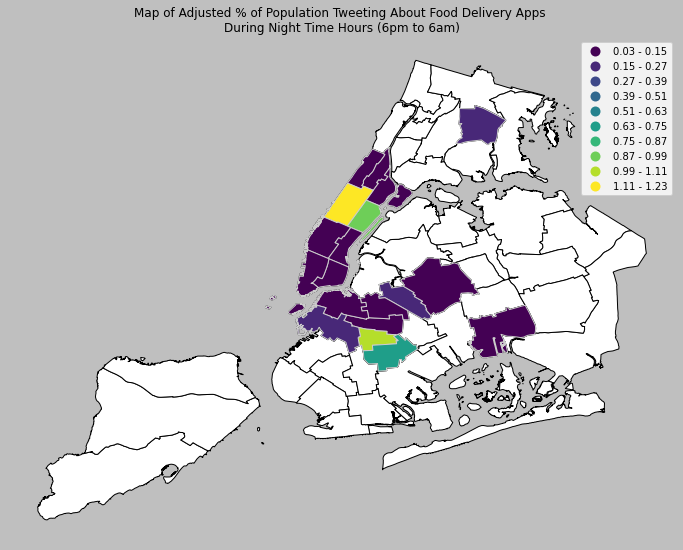

In [32]:
## plotting once using the pylab
# Setup figure and axis
f, ax = plt.subplots(1, figsize = (12,10))
# Plot layer of polygons on the axis
pumas.plot(ax = ax ,color = 'white',edgecolor = 'black')
# Plot layer of polygons on the axis
resPuma.plot(ax = ax ,column = 'adj_pct_pop',
         edgecolor='0.8', k = 10, 
         scheme = 'Equal_interval',legend = True)
# Remove axis frames
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.75')
# Display
plt.title('Map of Adjusted % of Population Tweeting About Food Delivery Apps \nDuring Night Time Hours (6pm to 6am)',
          fontdict = {'fontsize' : 12})
# Display
plt.show()
f.savefig('./foodapp/all_food_apps.png')

/home/cusp/yg833/.conda/envs/yelpVE/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 0, 18.
  warnings.warn(message)


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 18, ' is an island (no neighbors)')
The Global Moran's I for Across All Food Delivery Applications is 0.06798 and the p-value is 0.209


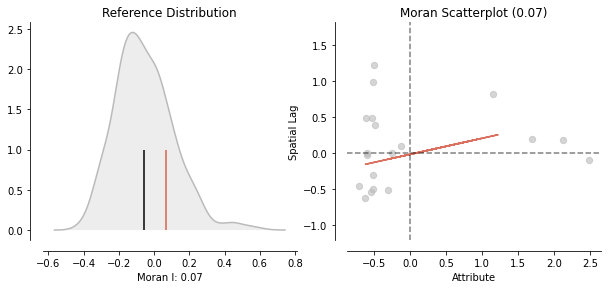

In [33]:
y = resPuma['adj_pct_pop']
w = Queen.from_dataframe(resPuma)
w.transform = 'r'
    
moran = Moran(y, w)
print("The Global Moran's I for {app} is {morani} and the p-value is {p}".format(app = 'Across All Food Delivery Applications',
                                                                                     morani = round(moran.I, 5),
                                                                                     p = round(moran.p_sim,5)))
    
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()
f.savefig('./foodapp/moran.png')

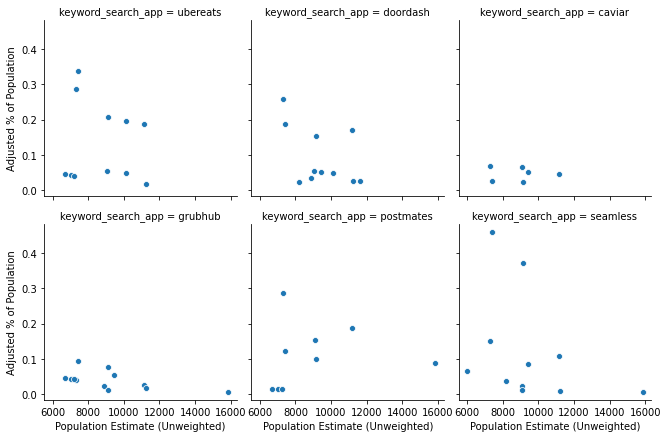

In [34]:
g = sns.FacetGrid(res, col="keyword_search_app", col_wrap=3)
g.map_dataframe(sns.scatterplot, x="B00001_001E", y="adj_pct_pop")
g.set_axis_labels("Population Estimate (Unweighted)","Adjusted % of Population")
g.add_legend()

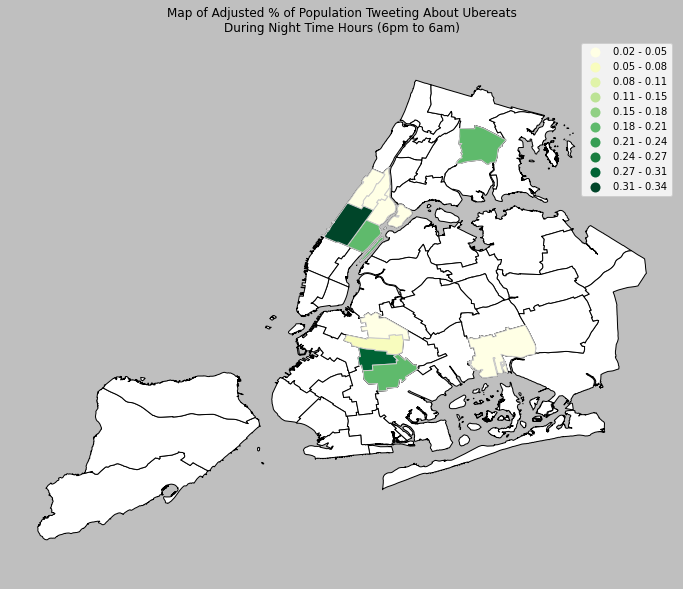

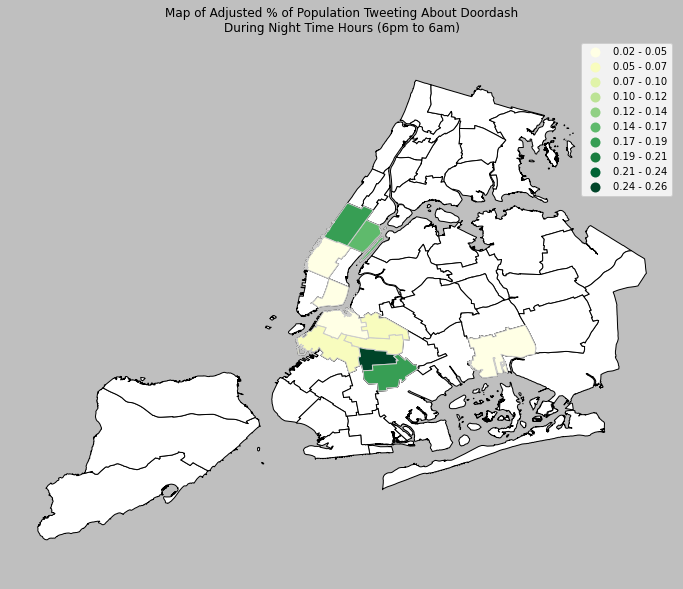

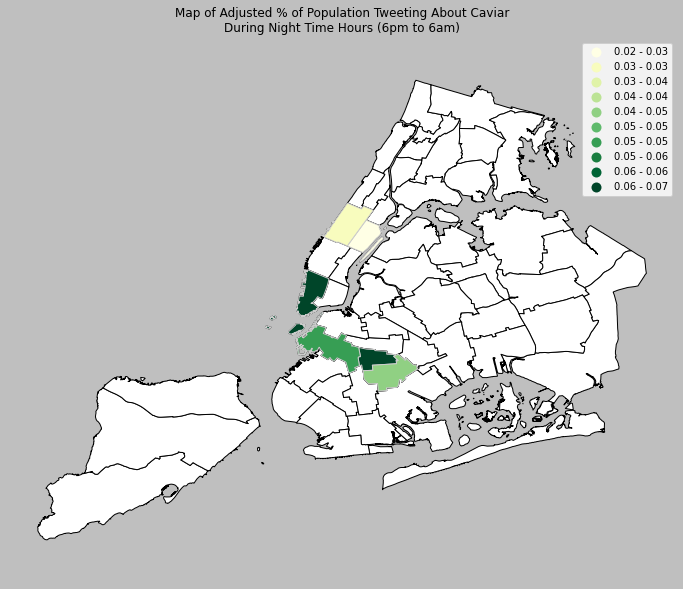

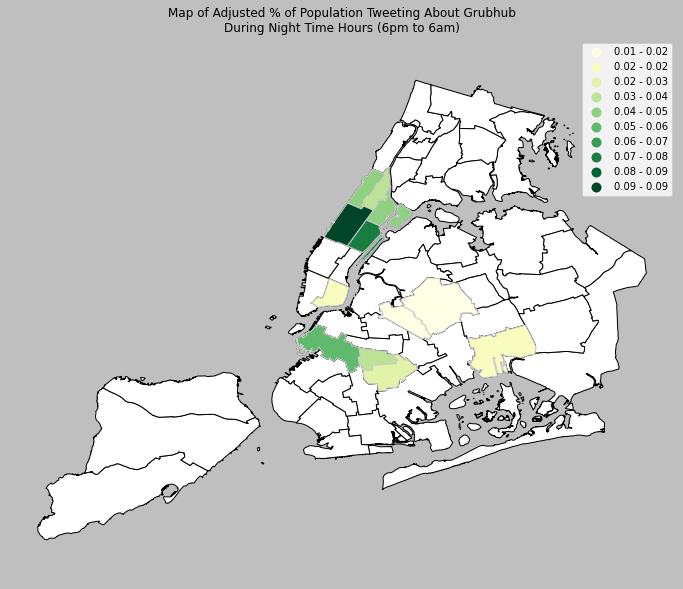

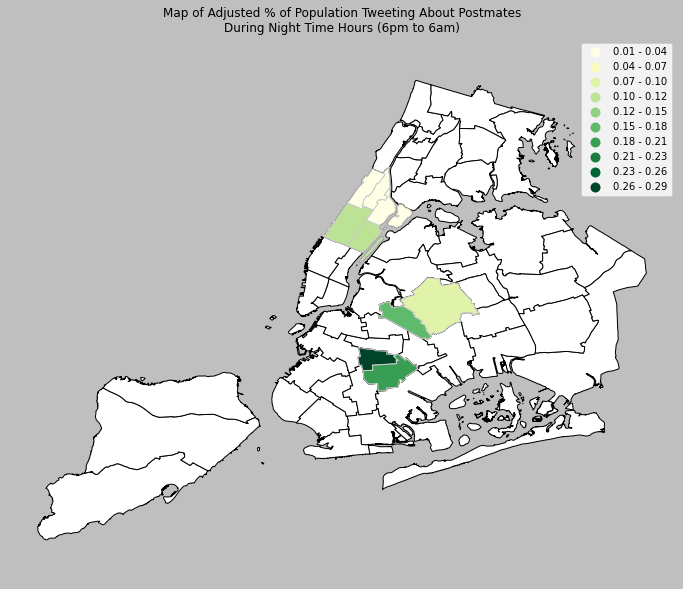

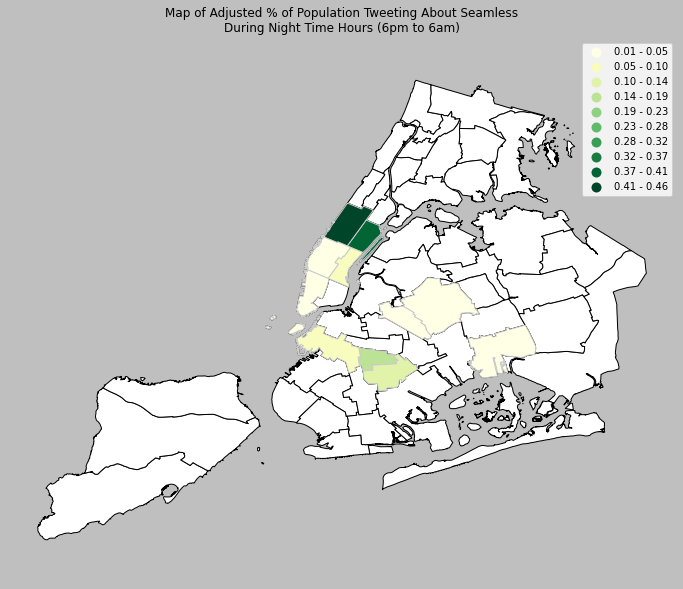

In [35]:
for app in res.keyword_search_app.unique():
    ## plotting once using the pylab
    # Setup figure and axis
    f, ax = plt.subplots(1, figsize = (12,10))
    # Plot layer of polygons on the axis
    pumas.plot(ax = ax ,color = 'white',edgecolor = 'black')
    # Plot layer of polygons on the axis
    res[res.keyword_search_app == app].plot(ax = ax ,column = 'adj_pct_pop',
             edgecolor='0.8', k = 10, cmap='YlGn',
             scheme = 'Equal_interval',legend = True)
    # Remove axis frames
    ax.set_axis_off()
    # Change background color of the figure
    f.set_facecolor('0.75')
    # Keep axes proportionate
    plt.axis('equal')
    # Display
    plt.title('Map of Adjusted % of Population Tweeting About '+ str.title(app) 
              + '\nDuring Night Time Hours (6pm to 6am)', fontdict = {'fontsize' : 12})
    f.savefig('./foodapp/'+app+'.png')

### Is there Global Spatial Autocorrelation?

/home/cusp/yg833/.conda/envs/yelpVE/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 2 islands with ids: 0, 10.
  warnings.warn(message)


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
The Global Moran's I for Ubereats is -0.12818 and the p-value is 0.499


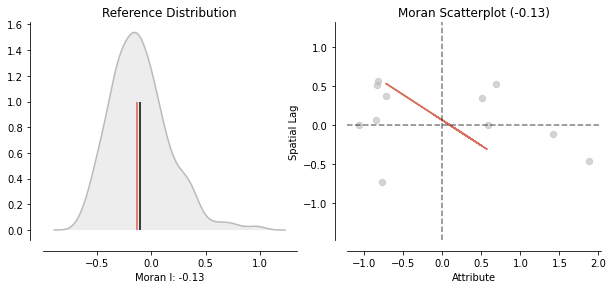

/home/cusp/yg833/.conda/envs/yelpVE/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 10.
  warnings.warn(message)


('WARNING: ', 10, ' is an island (no neighbors)')
The Global Moran's I for Doordash is 0.17491 and the p-value is 0.125


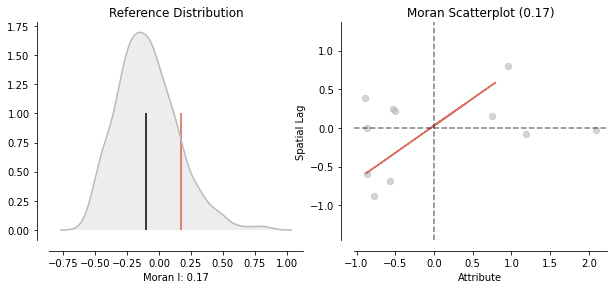

/home/cusp/yg833/.conda/envs/yelpVE/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


The Global Moran's I for Caviar is 0.65235 and the p-value is 0.062


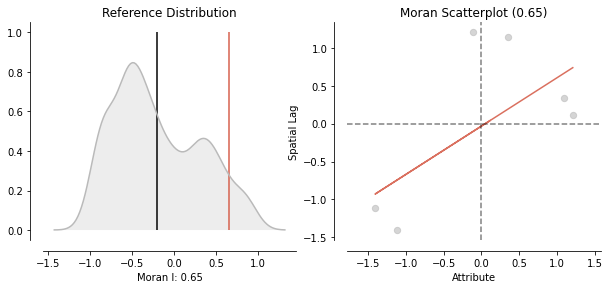

/home/cusp/yg833/.conda/envs/yelpVE/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 2 islands with ids: 6, 11.
  warnings.warn(message)


('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
The Global Moran's I for Grubhub is 0.63083 and the p-value is 0.012


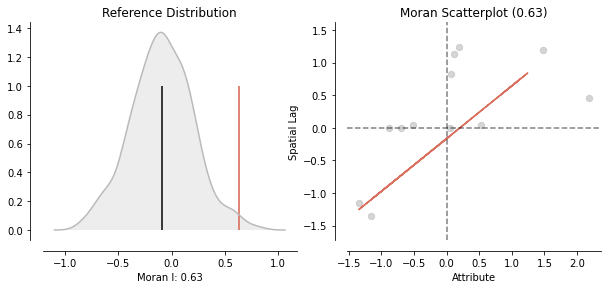

/home/cusp/yg833/.conda/envs/yelpVE/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


The Global Moran's I for Postmates is 0.56621 and the p-value is 0.013


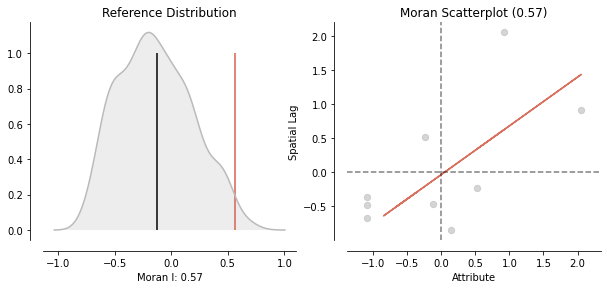

/home/cusp/yg833/.conda/envs/yelpVE/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 10.
  warnings.warn(message)


('WARNING: ', 10, ' is an island (no neighbors)')
The Global Moran's I for Seamless is 0.30426 and the p-value is 0.075


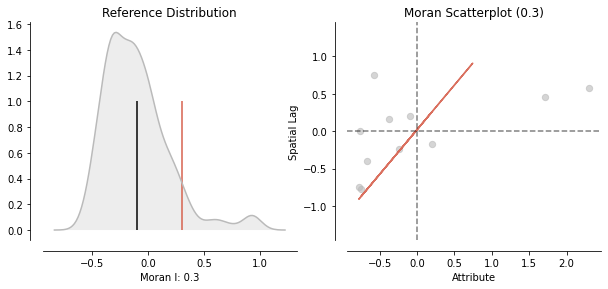

In [36]:
for app in res.keyword_search_app.unique():
    y = res[res.keyword_search_app==app]['adj_pct_pop']
    w = Queen.from_dataframe(res[res.keyword_search_app==app])
    w.transform = 'r'
    
    moran = Moran(y, w)
    print("The Global Moran's I for {app} is {morani} and the p-value is {p}".format(app = str.title(app),
                                                                                     morani = round(moran.I, 5),
                                                                                     p = round(moran.p_sim,5)))
    
    plot_moran(moran, zstandard=True, figsize=(10,4))
    plt.show()
    f.savefig('./foodapp/'+app+'_moran.png')